In [9]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
# import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
fontsize = 12

In [18]:
path = r"C:\Users\Angeliki\Anaconda3\1Sadia\My work\Data"
rpath = r"C:\Users\Angeliki\Anaconda3\1Sadia\My work\Results"


In [15]:

class StockPredictor(object):
    def __init__(self, data,
                 n_steps_frac_change, n_steps_frac_high,
                 n_steps_frac_low,n_latency_days=10, test_size=0.20,
                 n_hidden_states=4, ):
        
        self.n_latency_days = n_latency_days
        self.data = data
        self.hmm = GaussianHMM(n_components=n_hidden_states)
 
        self._split_train_test_data(test_size)
 
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    
    def _split_train_test_data(self, test_size):
        data = self.data
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
        
    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Adj Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])
 
        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((frac_change, frac_high, frac_low))
 
    def fit(self):
        feature_vector = StockPredictor._extract_features(self._train_data)
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
 
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_start_index: previous_data_end_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
        return most_probable_outcome
 
    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(
            day_index)
        return open_price * (1 + predicted_frac_change)
 
    def predict_close_prices_for_days(self):
        predicted_close_prices = []
        for day_index in tqdm(range(len(self._test_data))):
            predicted_close_prices.append(self.predict_close_price(day_index))
 
        return self._train_data,self._test_data,predicted_close_prices




In [19]:
data = pd.read_csv(path+"/Netflix dataset.csv")
data['Date'] = pd.to_datetime(data['Date'])

values = (20,5,5)
mse_score = pd.DataFrame()
stock_predictor = StockPredictor(data,n_steps_frac_change=values[0], n_steps_frac_high=values[1],
                 n_steps_frac_low=values[2])
stock_predictor.fit()
train,actual,pred = stock_predictor.predict_close_prices_for_days( )

mse_score = mse_score.append({"value":values[0]*values[1]*values[2],"mse":mean_squared_error(actual['Adj Close'],pred)},ignore_index=True)


plt.figure(figsize=(20,10))
plt.plot(actual['Date'],actual['Adj Close'],label = "Actual train")
# plt.plot(data['Date'],data['Adj Close'],label = "Actual train")

plt.plot(actual['Date'],pred,label = "HMM prediction" )

ax = plt.xticks(fontsize=fontsize)
ax = plt.yticks(fontsize=fontsize)
ax = plt.legend(fontsize=fontsize)
ax = plt.xlabel("Date",fontsize=fontsize)
ax = plt.ylabel("Adjusted closing price",fontsize=fontsize)

prediction = pd.DataFrame({"Date":actual['Date'],"HMM_prediction":pred})


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:24<00:00,  8.33it/s]
C:\Users\Angeliki\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2020: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Angeliki\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Angeliki\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
x = data['Adj Close']
min_max_scaler = MinMaxScaler()
min_max_scaler = min_max_scaler.fit(np.array(x).reshape(-1,1))
y_actual = min_max_scaler.transform(np.array(actual['Adj Close']).reshape(-1,1))
y_pred = min_max_scaler.transform(np.array(pred).reshape(-1,1))



In [22]:
mse_score_normalized = mean_squared_error(y_actual,y_pred)

In [23]:
mse_score_normalized

0.0004813430019914853

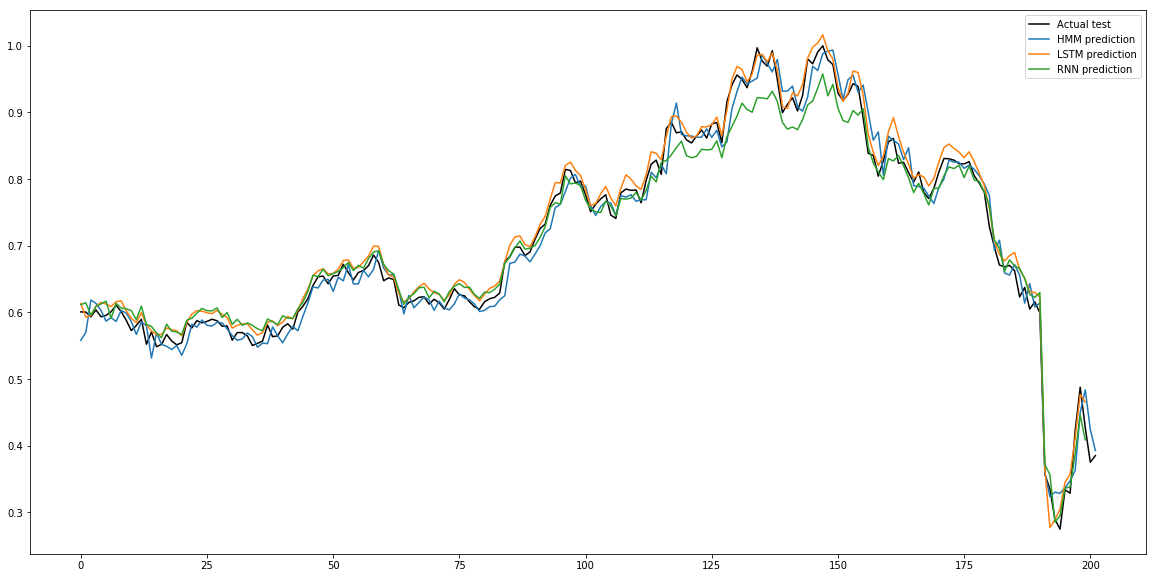

In [28]:
plt.figure(figsize=(20,10))
pred_lstm = pd.read_csv(rpath+"/LSTM ouput.csv").drop("Unnamed: 0",axis=1)
pred_rnn = pd.read_csv(rpath+"/RNN ouput.csv").drop("Unnamed: 0",axis=1)
plt.plot(y_actual,linewidth=1.5,color = 'k',label = "Actual test")
plt.plot(y_pred,label = "HMM prediction")
plt.plot(pred_lstm['pred'],label = "LSTM prediction")
plt.plot(pred_rnn['pred'],label = "RNN prediction")
plt.legend()
plt.show()





In [29]:
mse_score_hmm = mean_squared_error(y_actual,y_pred)
mse_score_lstm = mean_squared_error(pred_lstm['actual'],pred_lstm['pred'])
mse_score_rnn = mean_squared_error(pred_rnn['actual'],pred_rnn['pred'])
l = pd.DataFrame([mse_score_hmm,mse_score_rnn,mse_score_lstm],index = ["HMM",'RNN','LSTM'],columns = ['MSE score'])

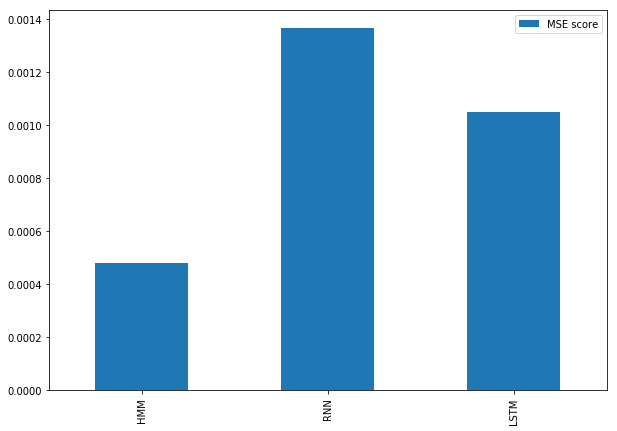

In [32]:
plt.figure()
l.plot(kind='bar',figsize = (10,7))
plt.show()